In [ ]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2


In [ ]:
sys.path = [ '/home/etsymbalov/.local/lib/python3.6/site-packages'] + sys.path

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks 
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP
from model.ensemble import MLPEnsemble
import pickle
import torch.nn.functional as F

plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
from dataloader.builder import build_dataset
from model.mlp import MLP
from uncertainty_estimator.masks import build_masks 
from experiment_setup import build_estimator
from analysis.metrics import get_uq_metrics
from experiments.utils.data import scale, split_ood, multiple_kfold

In [ ]:
import torch
torch.cuda.set_device(0)

In [ ]:
config = {
    'nn_runs': 100,
    'runs': 2,
    'max_runs': 20,
    'verbose': False,
    # Our train config
#    'layers': [8, 32, 32, 16, 1],
    'layers': [8, 128, 128, 256, 1],
#     'layers': [8, 2048, 2048, 1024, 1],
    'epochs': 10_000,
    'validation_step': 100,
    
    'acc_percentile': 0.1,
    'patience': 10,
    'dropout_rate': 0.1,
    'dropout_uq': 0.1,
    'batch_size': 256,
    'dataset': 'kin8nm',
    'l2_reg': 1e-5,
    'ood_percentile': 90,
    
    'optimizer': {'type': 'Adam', 'lr': 0.01, 'weight_decay':1e-5},
    'n_split_runs': 5,
    'n_model_runs': 5,
    'n_ens': 2,
    'n_ue_runs': 5,
    'k_folds': 2,
    'verbose': False,
}


In [ ]:
train_opts = ['patience', 'dropout_rate', 'epochs', 'batch_size', 'validation_step']
config['train_opts'] = {k: config[k] for k in config if k in train_opts}


In [ ]:
dataset_name = 'energy_efficiency'

In [ ]:
dataset = build_dataset(dataset_name, val_split=0.01) 
x_set, y_set = dataset.dataset('train')
config['layers'][0] = x_set.shape[-1]

In [ ]:
kfold_iterator = multiple_kfold(2, 
                                len(x_set), 
                                2)

In [ ]:
for kfold_cnt, (val_idx, train_idx) in enumerate(kfold_iterator): 
    # MIND THE ORDER
    x_train, y_train = x_set[train_idx], y_set[train_idx]
    x_val, y_val = x_set[val_idx], y_set[val_idx]
    x_train, x_val, x_scaler = scale(x_train, x_val)
    y_train, y_val, y_scaler = scale(y_train, y_val)

    train_opts = config['train_opts'].copy()
    
    model = MLPEnsemble(config['layers'], 
                        n_models=config['n_ens'], 
                        activation = F.celu,
                        reduction='mean')
    model.fit((x_train, y_train),
              (x_val, y_val),
              **train_opts)
    break

In [ ]:
rts = np.linspace(.5, 10, 101)

In [ ]:
smd = model.models[-1]

In [ ]:
prediction = smd(x_val).cpu().numpy()
errors = np.abs(np.ravel(prediction) - np.ravel(y_val))


In [ ]:
xdata = []
estimations_idx = np.argsort(errors)[::-1]
for ratio in rts:
    rk = int(len(estimations_idx)*ratio/100.)
    xdata.append(np.median(errors[estimations_idx[:rk]]))
ideal = np.array(xdata)[:,None]*100.

In [ ]:
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS
# masks = build_masks(DEFAULT_MASKS)
masks = build_masks(['k_dpp'])

In [ ]:
xxxdata = []
for name in masks:
    print(name)
    mask = masks[name]

    modelq = smd
#     for modelq in models.models:
    if hasattr(mask, 'reset'):
        mask.reset()
    estimator = build_estimator(
        'mcdue_masked', modelq, 
        nn_runs=config['nn_runs'],
        dropout_mask=mask,
        dropout_rate=config['dropout_uq'])
    estimations = estimator.estimate(x_val)

    data = []
    estimations_idx = np.argsort(estimations)[::-1]
    for ratio in rts:
        rk = int(len(estimations_idx)*ratio/100.)
        data.append(np.median(errors[estimations_idx[:rk]]))
    here = np.array(data)[:,None]*100.
    here = here/ideal*100.
    xxxdata.append([name, here])

In [ ]:
dpp = mask.dpps[1]

In [ ]:
dpp.L_eig_vals


In [ ]:
corr = mask.layer_correlations[1].astype(np.double)

In [61]:
corr


array([[ 1.        ,  0.02719674,  0.4190493 , ..., -0.38396151,
         0.10546347, -0.16052082],
       [ 0.02719674,  1.        ,  0.35823066, ..., -0.01991635,
         0.40463207, -0.18657965],
       [ 0.4190493 ,  0.35823066,  1.        , ..., -0.44905071,
         0.17987659, -0.09103137],
       ...,
       [-0.38396151, -0.01991635, -0.44905071, ...,  1.        ,
        -0.45185168,  0.23341482],
       [ 0.10546347,  0.40463207,  0.17987659, ..., -0.45185168,
         1.        , -0.17158308],
       [-0.16052082, -0.18657965, -0.09103137, ...,  0.23341482,
        -0.17158308,  1.        ]])

In [71]:
from dppy.finite_dpps import FiniteDPP
import numpy.linalg as la
import seaborn as sns


In [63]:
dpp = FiniteDPP('likelihood', **{'L': corr})

In [65]:
dpp.L_eig_vals
dpp.size_k_dpp

0

In [ ]:
# dpp.sample_exact_k_dpp(230)

In [66]:
dpp.list_of_samples

[]

In [67]:
L_eig_vals, eig_vecs = la.eigh(corr)

In [68]:
size = 230
N = L_eig_vals.size
E_poly = np.zeros((size + 1, N + 1))
E_poly[0, :] = 1.0

# Recursive evaluation
for l in range(1, size + 1):
    for n in range(1, N + 1):
        E_poly[l, n] = E_poly[l, n-1] + L_eig_vals[n-1] * E_poly[l-1, n-1]

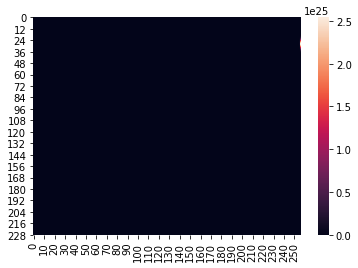

In [72]:
sns.heatmap(E_poly)

In [74]:
E_poly.shape


(231, 257)

In [87]:
np.max(E_poly[:30])


2.541523089336063e+25

In [131]:
import numpy as np
corr2 = np.eye(100)
corr2[range(10, 100), range(10, 100)] = 1e-12
dpp2 = FiniteDPP('likelihood', **{'L': corr2})
# dpp2.sample_exact_k_dpp(50)

In [132]:
L_eig_vals, eig_vecs = la.eigh(corr2)
size = 80
N = L_eig_vals.size
E_poly = np.zeros((size + 1, N + 1))
E_poly[0, :] = 1.0

# Recursive evaluation
for l in range(1, size + 1):
    for n in range(1, N + 1):
        E_poly[l, n] = E_poly[l, n-1] + L_eig_vals[n-1] * E_poly[l-1, n-1]


In [137]:
eig_vals = L_eig_vals
N, k = eig_vecs.shape[0], size

# as in np.linalg.matrix_rank
tol = np.max(eig_vals) * N * np.finfo(np.float).eps
rank = np.count_nonzero(eig_vals > tol)
if k > rank:
    raise ValueError('size k={} > rank={}'.format(k, rank))

ind_selected = np.zeros(k, dtype=int)
for n in range(eig_vals.size, 0, -1):
    if np.random.rand() < eig_vals[n-1] * E_poly[k-1, n-1] / E_poly[k, n]:
        k -= 1
        ind_selected[k] = n - 1
        if k == 0:
            break

V = eig_vecs[:, ind_selected]

/home/mephody_bro/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [144]:
size = 80

In [145]:
from dppy.utils import inner1d
rng = np.random

In [148]:
N, rank = V.shape  # ground set size / rank(K)
if size is None:  # full projection DPP
    size = rank
# else: k-DPP with k = size

ground_set = np.arange(N)
sampl = np.zeros(size, dtype=int)  # sample list
avail = np.ones(N, dtype=bool)  # available items

# Phase 1: Already performed!
# Select eigvecs with Bernoulli variables with parameter = eigvals of K.

# Phase 2: Chain rule
# Use Gram-Schmidt recursion to compute the Vol^2 of the parallelepiped spanned by the feature vectors associated to the sample

c = np.zeros((N, size))
norms_2 = inner1d(V, axis=1)  # ||V_i:||^2

In [149]:
norms_2

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 80.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:

for it in range(size):
    # Pick an item \propto this squred distance
    probabilities = np.abs(norms_2[avail])
    j = rng.choice(ground_set[avail],
                         p=probabilities / np.sum(probabilities))
    sampl[it] = j
    if it == size - 1:
        break
    # Cancel the contribution of V_j to the remaining feature vectors
    avail[j] = False
    c[avail, it] =\
        (V[avail, :].dot(V[j, :]) - c[avail, :it].dot(c[j, :it]))\
        / np.sqrt(norms_2[j])

    norms_2[avail] -= c[avail, it]**2  # update residual norm^2
